In [1]:
from collections import Counter
from typing import Self
import functools as ft
import itertools as it

from common import SiteBasis

import cvxpy as cp
import picos as pc
import numpy as np
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.utils import commutator, count_qubits, hermitian_conjugated
from openfermion.transforms import jordan_wigner, bravyi_kitaev
import seaborn as sns
from scipy.linalg import null_space, eigvalsh
from scipy.special import ellipeinc
from scipy.sparse import csr_array
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
from bitarray import bitarray
from bitarray.util import count_and

%load_ext line_profiler

In [2]:
# An efficient implementation of Pauli string operations (arXiV:2405.19287)
# z is bits[::2], x is bits[1::2]

class PauliString:
    CODEC = {'I': bitarray('00'),
             'Z': bitarray('10'),
             'X': bitarray('01'),
             'Y': bitarray('11'),}
    MAT = {'I': np.diag([1, 1]),
           'Z': np.diag([1, -1]),
           'X': np.fliplr(np.diag([1, 1])),
           'Y': np.fliplr(np.diag([-1j, 1j]))}
    def __init__(self, label: str | Self = None, bits: bitarray = None):
        self.bits = None
        self._str = None
        if not ((label is None) ^ (bits is None)):
            raise ValueError("exactly one of label or bits must be provided")
        if bits is None:
            if isinstance(label, str):
                self.bits = bitarray()
                self.bits.encode(self.CODEC, label)
                self._str = label
            elif isinstance(label, PauliString):
                self.bits = label.bits.copy()
            else:
                raise TypeError(f"Unsupported type {type(label)}")
        else:
            if isinstance(bits, bitarray):
                self.bits = bits.copy()
            else:
                raise TypeError(f"Unsupported type {type(bits)}")
    
    def __hash__(self):
        return hash(str(self.bits))

    def __repr__(self):
        if self._str is None:
            self._str = ''.join(self.bits.decode(self.CODEC))
        return self._str
    
    def __eq__(self, other):
        """Equality of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.bits == other.bits

    def __mul__(self, other: Self):
        """Multiply two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other)

    def __or__(self, other: Self):
        """Commutator of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other) if not self.commutes_with(other) else None
    
    def __and__(self, other: Self):
        """Anticommutator of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other) if self.commutes_with(other) else None
    
    def commutes_with(self, other: Self):
        """Check if two Pauli bitarrays commute."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return count_and(self.bits[::2], other.bits[1::2]) % 2 == count_and(self.bits[1::2], other.bits[::2]) % 2
    
    def phase(self, other: Self):
        """Find the phase of the product of two Pauli bitarrays."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return (-1j) ** ((2 * count_and(self.bits[1::2], other.bits[::2])
                          + count_and(self.bits[::2], self.bits[1::2])
                          + count_and(other.bits[::2], other.bits[1::2])
                          - count_and(self.bits[::2] ^ other.bits[::2], self.bits[1::2] ^ other.bits[1::2])) % 4)
    
    def multiply(self, other: Self):
        """Return the Pauli bitarray corresponding to the product of two Pauli bitarrays."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return PauliString(bits=self.bits ^ other.bits)
    
    def to_matrix(self):
        """Return the matrix corresponding to this Pauli string."""
        return ft.reduce(np.kron, (self.MAT[p] for p in self.__repr__()))

class PauliSum:
    # Consider implementing __iter__
    def __init__(self, labels_and_weights: dict[str, complex] | str | PauliString | Self):
        self.terms = None
        if isinstance(labels_and_weights, dict):
            self.terms = self.clean(Counter({PauliString(label): weight for label, weight in labels_and_weights.items()}))
        elif isinstance(labels_and_weights, str):
            self.terms = Counter({PauliString(labels_and_weights): 1.0})
        elif isinstance(labels_and_weights, PauliString):
            self.terms = Counter({PauliString(bits=labels_and_weights.bits): 1.0})
        elif isinstance(labels_and_weights, PauliSum):
            self.terms = labels_and_weights.terms.copy()
        else:
            raise TypeError(f"Unsupported type {type(labels_and_weights)}")
    
    def __hash__(self):
        raise NotImplementedError
    
    def __eq__(self, other: Self):
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        if self.terms.keys() != other.terms.keys():
            return False
        for pstr, weight in self.terms.items():
            if not np.isclose(other.terms[pstr], weight):
                return False
        return True
    
    def __repr__(self):
        if self.is_zero():
            return f'{0j:.2f}'
        return '; '.join(f'{weight:.2f}*{string}' for string, weight in self.terms.items())
    
    def __iadd__(self, other: Self):
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        for pstr, weight in other.terms.items():
            self.terms[pstr] += weight
            if np.isclose(self.terms[pstr], 0):
                del self.terms[pstr]
        return self
    
    def __add__(self, other: Self):
        res = PauliSum(self)
        res += other
        return res

    def __imul__(self, other: complex):
        if not isinstance(other, complex):
            raise TypeError("other is not a complex")
        for pstr in self.terms:
            self.terms[pstr] *= other
        return self

    def __rmul__(self, other: complex):
        if not isinstance(other, complex):
            raise TypeError("other is not a complex")
        res = PauliSum(self)
        res *= other
        return res

    def __mul__(self, other: Self | complex):
        """Multiply two PauliSums."""
        if isinstance(other, PauliSum):
            res = Counter()
            for l1, w1 in self.terms.items():
                for l2, w2 in other.terms.items():
                    res[l1 * l2] += l1.phase(l2) * w1 * w2
            return PauliSum(res)
        elif isinstance(other, complex):
            res = PauliSum(self)
            res *= other
            return res
        raise TypeError(f"Unsupported type {type(other)}")

    def __or__(self, other: Self):
        """Commutator of two PauliSums."""
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        res = Counter()
        for l1, w1 in self.terms.items():
            for l2, w2 in other.terms.items():
                if not l1.commutes_with(l2):
                    res[l1 * l2] += 2 * l1.phase(l2) * w1 * w2
        return PauliSum(res)

    def __and__(self, other: Self):
        """Anticommutator of two PauliSums."""
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        res = Counter()
        for l1, w1 in self.terms.items():
            for l2, w2 in other.terms.items():
                if l1.commutes_with(l2):
                    res[l1 * l2] += 2 * l1.phase(l2) * w1 * w2
        return PauliSum(res)
    
    def is_zero(self):
        return not self.terms
    
    @staticmethod
    def _pauli_ord(row: np.ndarray, col: np.ndarray, n: int) -> None:
        if n == 1:
            row[0], col[0] = 0, 0
            row[1], col[1] = 1, 1
            row[2], col[2] = 0, 1
            row[3], col[3] = 1, 0
            return
        PauliSum._pauli_ord(row, col, n - 1)
        pw = 1 << (2 * (n - 1))
        row[1 * pw: 2 * pw] = row[:pw] + (1 << (n - 1))
        col[1 * pw: 2 * pw] = col[:pw] + (1 << (n - 1))
        row[2 * pw: 3 * pw] = row[:pw]
        col[2 * pw: 3 * pw] = col[:pw] + (1 << (n - 1))
        row[3 * pw: 4 * pw] = row[:pw] + (1 << (n - 1))
        col[3 * pw: 4 * pw] = col[:pw]

    @staticmethod
    def _mat_to_vec(matrix: np.ndarray) -> np.ndarray:
        """
        Vectorizes a matrix in Pauli order.
                                                              [vec(A)]
        Given a matrix M = [A B], we vectorize it as vec(M) = [vec(D)].
                           [C D]                              [vec(B)]
                                                              [vec(C)]

        Args:
            matrix: The matrix to vectorize.
        """
        log2n = int(matrix.shape[0]).bit_length() - 1
        row = np.zeros(4 ** log2n, dtype=np.int64)
        col = np.zeros(4 ** log2n, dtype=np.int64)
        PauliSum._pauli_ord(row, col, log2n)
        flat_index = (1 << log2n) * row + col
        return matrix.reshape(-1)[flat_index].astype(np.complex128)

    @staticmethod
    def matrix_decomposition(matrix: np.ndarray) -> np.ndarray:
        """
        Return the weight vector corresponding to the Pauli basis decomposition of a matrix.
        The ordering is IZXY.

        Args:
            matrix: The matrix to be decomposed.
        """
        if matrix.ndim != 2:
            raise ValueError("matrix must be a 2D ndarray")
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError(f"expected square matrix but matrix dimensions \
                            are ({matrix.shape[0]}, {matrix.shape[1]})")
        if matrix.shape[0] == 1:
            raise ValueError("input must be a matrix, not a scalar")
        if int(matrix.shape[0]).bit_count() != 1:
            raise ValueError(f"expected square matrix with power of two \
                            dimensions but matrix dimensions are \
                            ({matrix.shape[0]}, {matrix.shape[1]})")
        b = PauliSum._mat_to_vec(matrix)
        h = 1
        while h < b.shape[0]:
            for i in range(0, b.shape[0], 4 * h):
                x, y = b[i : i + h], b[i + h : i + 2 * h]
                b[i : i + h], b[i + h : i + 2 * h] = (x + y) / 2, (x - y) / 2
                z, w = b[i + 2 * h : i + 3 * h], b[i + 3 * h : i + 4 * h]
                b[i + 2 * h : i + 3 * h], b[i + 3 * h : i + 4 * h] = (z + w) / 2, 1j * (z - w) / 2
            h *= 4
        return b

    @classmethod
    def from_matrix(cls, mat: np.ndarray):
        L = int(mat.shape[0]).bit_length() - 1
        wvec = PauliSum.matrix_decomposition(mat)
        obj = Counter()
        for i, op in enumerate(it.product('IZXY', repeat=L)):
            sop = ''.join(op)
            obj[sop] += wvec[i]
        return PauliSum(obj)

    def to_matrix(self):
        return sum(weight * pstr.to_matrix() for pstr, weight in self.terms.items())

    def clean(self, dirty_counter: Counter):
        """Remove zero terms."""
        return Counter({label: weight for label, weight in dirty_counter.items() if not np.isclose(weight, 0)})

In [3]:
def schwinger_dyson(hamil: PauliSum, word1: str) -> PauliSum:
    return hamil | PauliSum(word1)

def ground_state(hamil: PauliSum, word1: str) -> PauliSum:
    return PauliSum(word1) * (hamil | PauliSum(word1))

def beta_independent_constraints(basis: SiteBasis, hamil: PauliSum) -> tuple[np.ndarray, np.ndarray]:
    # We handle normalization separately
    n_cols = basis.size() - 1
    A = np.zeros((n_cols, n_cols), dtype=complex)
    # A = zeros(n_cols, n_cols)
    for i, word in enumerate(basis._ops[1:]):
        psum = schwinger_dyson(hamil, word)
        if psum.is_zero():
            continue
        for pstr, weight in psum.terms.items():
            A[i, basis.rank(str(pstr)) - 1] += weight
    return 1j * A

def construct_hamil(L: int, h: float) -> PauliSum:
    hamil = Counter()
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil[t1] = -1
        hamil[t2] = -h
    if L == 2:
        hamil = Counter({'IZ': -h, 'ZI': -h, 'XX': -1})
    return PauliSum(hamil)

In [2]:
%lprun -f SiteBasis.__init__ SiteBasis(8, use_reflect=True, use_rot=True)

Timer unit: 1e-07 s

Total time: 0.162236 s
File: c:\mtp\my-work\ising\common.py
Function: __init__ at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                               def __init__(self, L, use_rot=False, use_reflect=False):
     6         1         23.0     23.0      0.0          self._N = L
     7         1         15.0     15.0      0.0          self._opset = set()
     8         1          4.0      4.0      0.0          exclude = set()
     9     65537     183510.0      2.8     11.3          for o in product('IXYZ', repeat=L):
    10     65536     204449.0      3.1     12.6              op = ''.join(o)
    11     65536     298372.0      4.6     18.4              if op in exclude:
    12     61101     126186.0      2.1      7.8                  continue
    13      4435      17006.0      3.8      1.0              self._opset.add(op)
    14      4435      11162.0      2.5      0.7              if use_rot:
    15      4435    

In [25]:
def get_zero_ops(L, small_basis):
    hamil = construct_hamil(L, 1)
    A = beta_independent_constraints(small_basis, hamil)
    A_ns = null_space(A)
    zero_ops = set(np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
    return zero_ops

def build_sparsity_matrix(basis: SiteBasis, zero_ops):
    small_basis = SiteBasis(basis._N, use_rot=True, use_reflect=True)
    sparsity = np.ones((basis.size(), basis.size()), dtype=np.int8)
    for i, o1 in enumerate(basis._ops):
        for j, o2 in enumerate(basis._ops):
            op = str(PauliString(o1) * PauliString(o2))
            opr = small_basis.rank(op)
            if opr - 1 in zero_ops:
                sparsity[i, j] = 0
    return sparsity

def build_phase_matrix(basis: SiteBasis, zero_ops):
    small_basis = SiteBasis(basis._N, use_rot=True, use_reflect=True)
    phase = np.ones((basis.size(), basis.size()), dtype=np.int8)
    for i, o1 in enumerate(basis._ops):
        for j, o2 in enumerate(basis._ops):
            p1 = PauliString(o1)
            p2 = PauliString(o2)
            if small_basis.normalize(str(p1 * p2)) in zero_ops:
                phase[i, j] = 0
            else:
                p = p1.phase(p2)
                if np.isclose(p, -1j):
                    phase[i, j] = 1
                elif np.isclose(p, -1):
                    phase[i, j] = 2
                elif np.isclose(p, 1j):
                    phase[i, j] = 3
                elif np.isclose(p, 1):
                    phase[i, j] = 4
                else:
                    raise ValueError("Unexpected phase")
    return phase

def get_reorder(matrix):
    n_cc, labels = connected_components(csr_array(matrix), directed=False)
    reord = [y for y, _ in sorted(enumerate(labels), key=lambda x: x[1])]
    return n_cc, reord

def reorder_by_cc(matrix):
    _, reord = get_reorder(matrix)
    return matrix[:, reord][reord, :]

def plot_heatmap(matrix, basis, ax):
    # print('Fraction of nonzeros:', len(np.nonzero(matrix)[0]) / basis.size() ** 2)
    sns.heatmap(matrix, xticklabels=False, yticklabels=False, ax=ax, cbar=False)

In [ ]:
L = 4
basis = SiteBasis(L)
small_basis = SiteBasis(L, True, True)
sparsity = build_sparsity_matrix(basis, get_zero_ops(L, small_basis))
reord_sparsity = reorder_by_cc(sparsity)
small_basis = SiteBasis(L, use_rot=True, use_reflect=True)
sparsity_small = build_sparsity_matrix(small_basis, get_zero_ops(L, small_basis))
reord_sparsity_small = reorder_by_cc(sparsity_small)
phase = build_phase_matrix(basis, get_zero_ops(L))
reord_phase = reorder_by_cc(phase)
phase_small = build_phase_matrix(small_basis, get_zero_ops(L))
reord_phase_small = reorder_by_cc(phase_small)

Fraction of nonzeros: 18432
Fraction of nonzeros: 18432
Fraction of nonzeros: 953
Fraction of nonzeros: 953


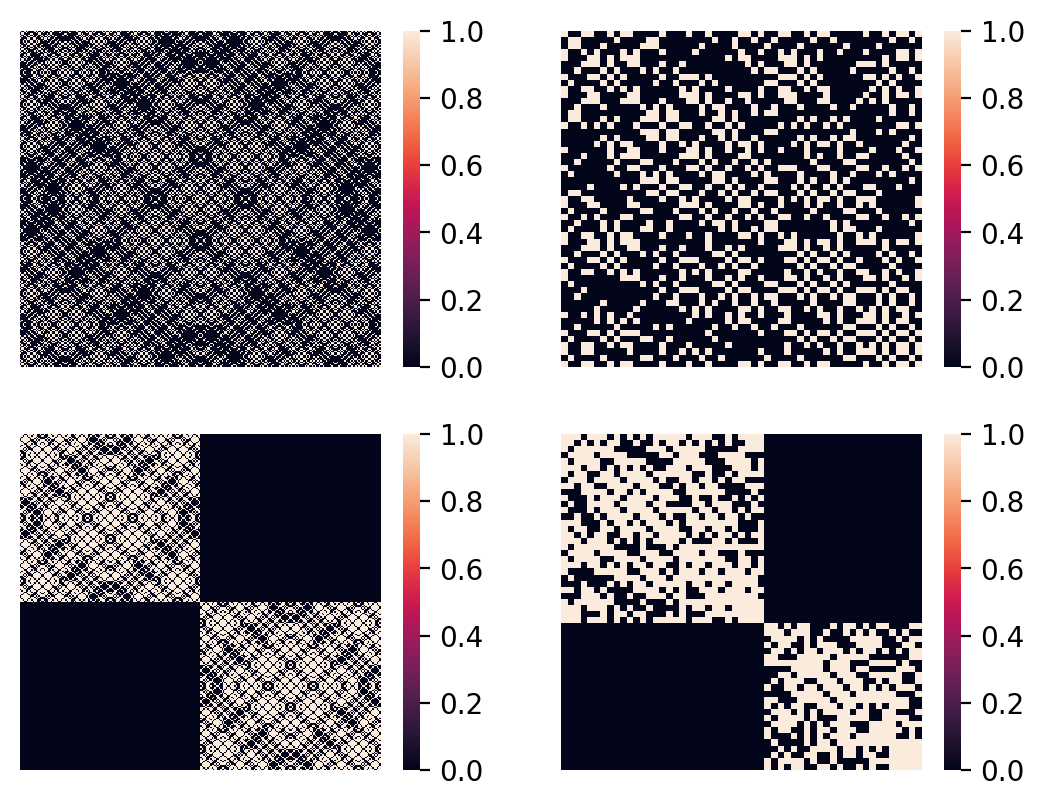

In [39]:
fig, axs = plt.subplots(2, 2)
plot_heatmap(sparsity, basis, axs[0, 0])
plot_heatmap(reord_sparsity, basis, axs[1, 0])
plot_heatmap(sparsity_small, small_basis, axs[0, 1])
plot_heatmap(reord_sparsity_small, small_basis, axs[1, 1])
fig.set_dpi(200)
plt.show()

Fraction of nonzeros: 18432
Fraction of nonzeros: 18432
Fraction of nonzeros: 953
Fraction of nonzeros: 953


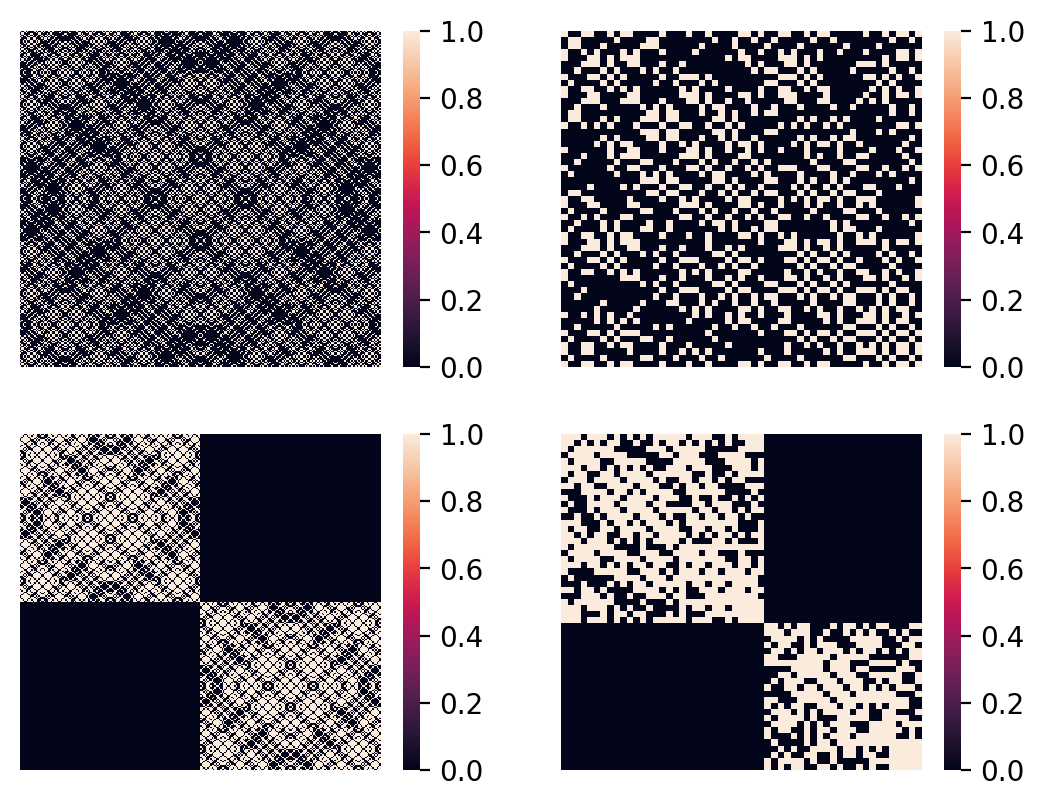

In [42]:
fig, axs = plt.subplots(2, 2)
plot_heatmap(sparsity, basis, axs[0, 0])
plot_heatmap(reord_sparsity, basis, axs[1, 0])
plot_heatmap(sparsity_small, small_basis, axs[0, 1])
plot_heatmap(reord_sparsity_small, small_basis, axs[1, 1])
fig.set_dpi(200)
plt.show()

Fraction of nonzeros: 0.28125
Fraction of nonzeros: 0.28125
Fraction of nonzeros: 0.3150413223140496
Fraction of nonzeros: 0.3150413223140496


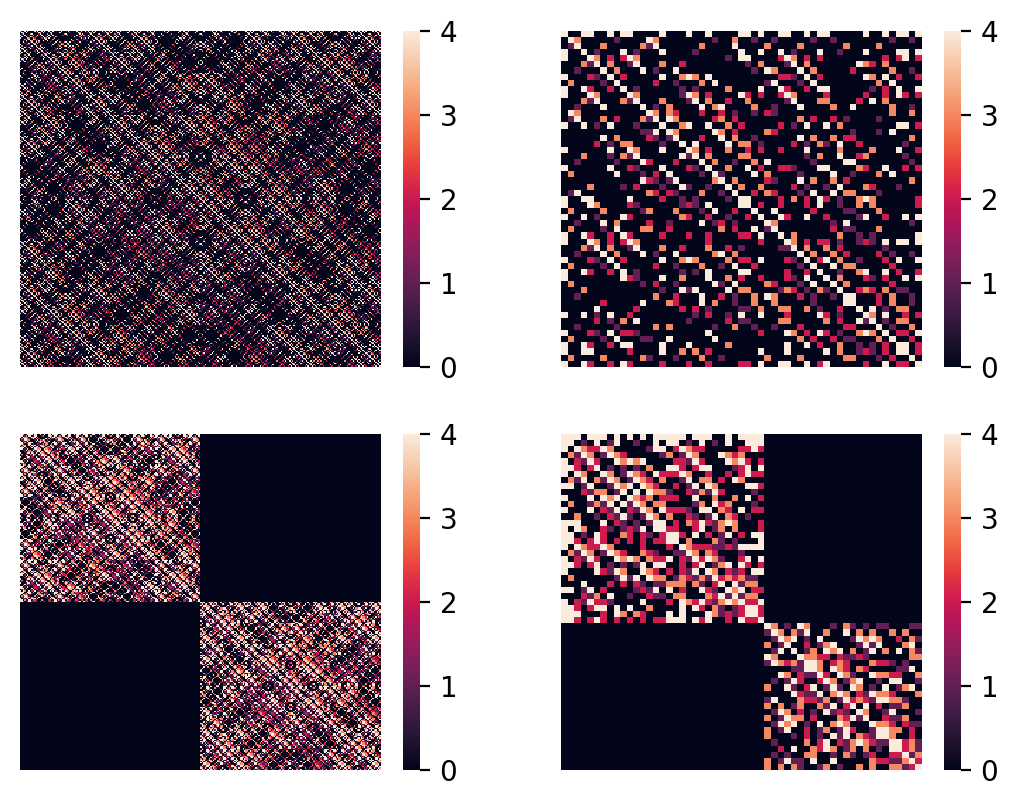

In [455]:
fig, axs = plt.subplots(2, 2)
plot_heatmap(phase, basis, axs[0, 0])
plot_heatmap(reord_phase, basis, axs[1, 0])
plot_heatmap(phase_small, small_basis, axs[0, 1])
plot_heatmap(reord_phase_small, small_basis, axs[1, 1])
fig.set_dpi(200)
plt.show()

In [4]:
# Now decompose everything
def get_bases(L):
    basis = SiteBasis(L)
    small_basis = SiteBasis(L, use_rot=True, use_reflect=True)
    return basis, small_basis

def decompose(op: PauliSum, A_ns, small_basis):
    res = np.zeros(A_ns.shape[1], dtype=np.complex128)
    for pstr, weight in op.terms.items():
        res += weight * A_ns[small_basis.rank(str(pstr)) - 1, :]
    return res

def get_decomp(A_ns, ops, small_basis):
    decomp_mats = np.zeros((A_ns.shape[1], len(ops), len(ops)), dtype=np.complex128)
    for i, o1 in enumerate(ops):
        for j, o2 in enumerate(ops):
            if i <= j:
                continue
            p1 = PauliString(o1)
            p2 = PauliString(o2)
            p3 = p1 * p2
            decomp_mats[:, i, j] += p1.phase(p2) * A_ns[small_basis.rank(str(p3)) - 1, :]
    return decomp_mats + decomp_mats.conj().transpose((0, 2, 1))

def decompose_sb(op: PauliSum, small_basis):
    res = np.zeros(small_basis.size() - 1, dtype=np.complex128)
    for pstr, weight in op.terms.items():
        res[small_basis.rank(str(pstr)) - 1] += weight
    return res

def get_decomp_sb(ops, small_basis):
    decomp_mats = np.zeros((small_basis.size() - 1, len(ops), len(ops)), dtype=np.complex128)
    for i, o1 in enumerate(ops):
        for j, o2 in enumerate(ops):
            if i <= j:
                continue
            p1 = PauliString(o1)
            p2 = PauliString(o2)
            p3 = p1 * p2
            decomp_mats[small_basis.rank(str(p3)) - 1, i, j] += p1.phase(p2)
    return decomp_mats + decomp_mats.conj().transpose((0, 2, 1))

In [5]:
def analytical_energy(h):
    return (2 * np.abs(1 - h) / np.pi) * ellipeinc(np.pi / 2, -4 * h / (1 - h) ** 2)

def calculated_energy(L, h):
    H = construct_hamil(L, h).to_matrix()
    return eigvalsh(H, subset_by_index=[0, 0])[0]

def calculated_energies(L, hs):
    energies = np.zeros_like(hs)
    for i, h in enumerate(hs):
        print(f'Solving {h:.4f}...')
        energies[i] = -calculated_energy(L, h)/L
    return energies

def dm_energy(L, h):
    prob = pc.Problem()
    hamil = construct_hamil(L, h)
    H = hamil.to_matrix()
    # H = csr_array(hamil.to_matrix())
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("min", pc.trace(rho | H))
    prob.add_constraint(pc.trace(rho) == 1)
    prob.add_constraint(rho >> 0)
    return prob.solve()

def dm_energies(L, hs):
    energies = np.zeros_like(hs)
    for i, h in enumerate(hs):
        # print(f'Solving {h:.4f}...')
        energies[i] = -dm_energy(L, h).value/L
    return energies

def get_energy(hamil, small_basis, Ai_s1, Ai_s2) -> pc.Solution:
    prob = pc.Problem()
    # A = beta_independent_constraints(small_basis, hamil)
    # A_ns = null_space(A)
    # Ai_s1 = get_decomp(A_ns, spops1, small_basis)
    # Ai_s2 = get_decomp(A_ns, spops2, small_basis)
    # decomp_hamil = decompose(hamil, A_ns, small_basis)
    decomp_hamil = decompose_sb(hamil, small_basis)
    # This is the primal problem
    X = pc.SymmetricVariable("X", Ai_s1.shape[1])
    Y = pc.SymmetricVariable("Y", Ai_s2.shape[1])
    # v = pc.RealVariable("v", small_basis.size())
    prob.set_objective("max", -(pc.trace(X) +pc.trace(Y)))
    # prob.set_objective("max", -pc.trace(X))
    prob.add_constraint(X >> 0)
    prob.add_constraint(Y >> 0)
    prob.add_list_of_constraints([(Ai_s1[i] | X) + (Ai_s2[i] | Y) == decomp_hamil[i] for i in range(Ai_s1.shape[0])])
    # prob.add_list_of_constraints([(Ai_s1[i] | X) == decomp_hamil[i] for i in range(Ai_s1.shape[0])])
    # print(prob)
    return prob.solve()
    # This is the dual problem
    # x = pc.RealVariable("x", (A_ns.shape[1], 1))
    # prob.set_objective("min", decomp_hamil.T * x)
    # prob.add_constraint(pc.I(len(spops1)) + pc.sum([Ai_s1[i] * x[i] for i in range(A_ns.shape[1])]) >> 0)
    # prob.add_constraint(pc.I(len(spops2)) + pc.sum([Ai_s2[i] * x[i] for i in range(A_ns.shape[1])]) >> 0)
    # return prob.solve(dualize=True)

def get_energy_cvxpy(hamil, small_basis, Ai_s1, Ai_s2) -> pc.Solution:
    decomp_hamil = decompose_sb(hamil, small_basis)
    # This is the primal problem
    X = cp.Variable((Ai_s1.shape[1], Ai_s1.shape[1]), "X", PSD=True)
    Y = cp.Variable((Ai_s2.shape[1], Ai_s2.shape[1]), "Y", PSD=True)
    obj =  -(cp.trace(X) + cp.trace(Y))
    constraints = [cp.trace(Ai_s1[i] @ X) + cp.trace(Ai_s2[i] @ Y) == decomp_hamil[i] for i in range(Ai_s1.shape[0])]
    prob = cp.Problem(cp.Maximize(obj), constraints)
    return prob.solve()

def get_energies(L, hs):
    basis, small_basis = get_bases(L)
    hamil = construct_hamil(L, 1)
    A_ns = null_space(beta_independent_constraints(small_basis, hamil))
    # Now build the ops from the sparsity pattern
    solve_basis = small_basis
    zero_ops = set(np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
    sparsity = np.ones((solve_basis.size(), solve_basis.size()), dtype=np.int8)
    for i, o1 in enumerate(solve_basis._ops):
        for j, o2 in enumerate(solve_basis._ops):
            if i <= j:
                continue
            op = small_basis.rank(str(PauliString(o1) * PauliString(o2)))
            if op in zero_ops:
                sparsity[i, j] = sparsity[j, i] = 0
    _, reord = get_reorder(sparsity)
    spops1 = np.array(solve_basis._ops)[reord[:len(reord) // 2]]
    spops2 = np.array(solve_basis._ops)[reord[len(reord) // 2:]]
    Ai_s1 = get_decomp_sb(spops1, small_basis)
    Ai_s2 = get_decomp_sb(spops2, small_basis)
    energies = np.zeros_like(hs)
    for i, h in enumerate(hs):
        print(f'Solving {h:.4f}...')
        hamil = construct_hamil(L, h)
        # energies[i] = -get_energy_cvxpy(hamil, small_basis, Ai_s1, Ai_s2)/L
        energies[i] = -get_energy(hamil, small_basis, Ai_s1, Ai_s2).value/L
    return energies

In [6]:
get_energies(3, np.array([1]))

NameError: name 'get_reorder' is not defined

Solving 4
Solving 0.0010...
Solving 0.2231...
Solving 0.4452...
Solving 0.6673...
Solving 0.8894...
Solving 1.1116...
Solving 1.3337...
Solving 1.5558...
Solving 1.7779...
Solving 2.0000...
Solving 5
Solving 0.0010...
Solving 0.2231...
Solving 0.4452...
Solving 0.6673...
Solving 0.8894...
Solving 1.1116...
Solving 1.3337...
Solving 1.5558...
Solving 1.7779...
Solving 2.0000...
Solving 6
Solving 0.0010...
Solving 0.2231...
Solving 0.4452...
Solving 0.6673...
Solving 0.8894...
Solving 1.1116...
Solving 1.3337...
Solving 1.5558...
Solving 1.7779...
Solving 2.0000...


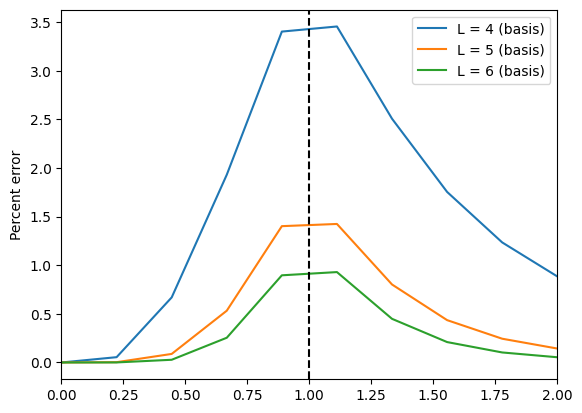

In [67]:
Ls = [4, 5, 6]
hs = np.linspace(1e-3, 2, num=10)
aE = analytical_energy(hs)
for L in Ls:
    print(f'Solving {L}')
    plt.plot(hs, 100 * np.abs(get_energies(L, hs) - aE) / aE, label=f'L = {L} (basis)')
    # plt.plot(hs, 100 * np.abs(dm_energies(L, hs) - aE) / aE, label=f'L = {L} (DM)')
plt.axvline(1, linestyle='--', c='black')
plt.xlim(0,2)
plt.ylabel('Percent error')
plt.legend()
plt.show()

In [507]:
%lprun -f get_energy get_energies(4, np.array([1]))

Solving 1.0000...


Timer unit: 1e-07 s

Total time: 1.80675 s
File: C:\Users\Mainak\AppData\Local\Temp\ipykernel_18300\4291279164.py
Function: get_energy at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def get_energy(L, h, small_basis, spops1, spops2) -> pc.Solution:
     5         1       1907.0   1907.0      0.0      prob = pc.Problem()
     6         1       4255.0   4255.0      0.0      hamil = construct_hamil(L, h)
     7         1     146316.0 146316.0      0.8      A = beta_independent_constraints(small_basis, hamil)
     8                                               # A_ns = null_space(A)
     9                                               # Ai_s1 = get_decomp(A_ns, spops1, small_basis)
    10                                               # Ai_s2 = get_decomp(A_ns, spops2, small_basis)
    11                                               # decomp_hamil = decompose(hamil, A_ns, small_basis)
    12         1    1591457.0 

In [28]:
def overlay_basis_on_heatmap(mat, basis, rbas, rbas_name, clr, ax):
    sparsity = mat.copy()
    for i, o1 in enumerate(basis._ops):
        for j, o2 in enumerate(basis._ops):
            op = str(PauliString(o1) * PauliString(o2))
            if op in rbas:
                sparsity[i, j] = 2
    sns.heatmap(sparsity, xticklabels=False, yticklabels=False, cmap=["black", "white", clr], ax=ax, square=True, vmin=0, vmax=2)
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([1 / 3, 1, 5 / 3])
    c_bar.set_ticklabels(['0', '1', rbas_name])

def berbasis0(L):
    rbas = set(['I' * L])
    for i in range(L):
        rbas.add('I' * i + 'X' + 'I' * (L - i - 1))
        rbas.add('I' * i + 'Y' + 'I' * (L - i - 1))
        rbas.add('I' * i + 'Z' + 'I' * (L - i - 1))
    return rbas

def berbasis1(L):
    rbas = set()
    for a in ['X', 'Y', 'Z']:
        for b in ['X', 'Y', 'Z']:
            rbas.add(a + b + 'I' * (L - 2))
    return rbas

def berbasis2(L):
    rbas = set()
    for a in ['X', 'Y', 'Z']:
        for b in ['X', 'Y', 'Z']:
            for i in range(L - 1):
                rbas.add('I' * i + a + b + 'I' * (L - i - 2))
    return rbas

def jw_basis(L):
    rbas = set()
    for i in range(L):
        rbas.add('Z' * i + 'X' + 'I' * (L - i - 1))
        rbas.add('Z' * i + 'Y' + 'I' * (L - i - 1))
    return rbas

def min_rho(L, h):
    hamil = construct_hamil(L, h)
    H = hamil.to_matrix()
    prob = pc.Problem()
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("min", pc.trace(rho | H))
    prob.add_constraint(pc.trace(rho) == 1)
    prob.add_constraint(rho >> 0)
    prob.solve()
    return rho

def dm_basis(L):
    dm = min_rho(L, 1)
    rho = np.array(dm.value)
    rho_ps = PauliSum.from_matrix(rho)
    return set([str(x) for x in rho_ps.terms.keys()])

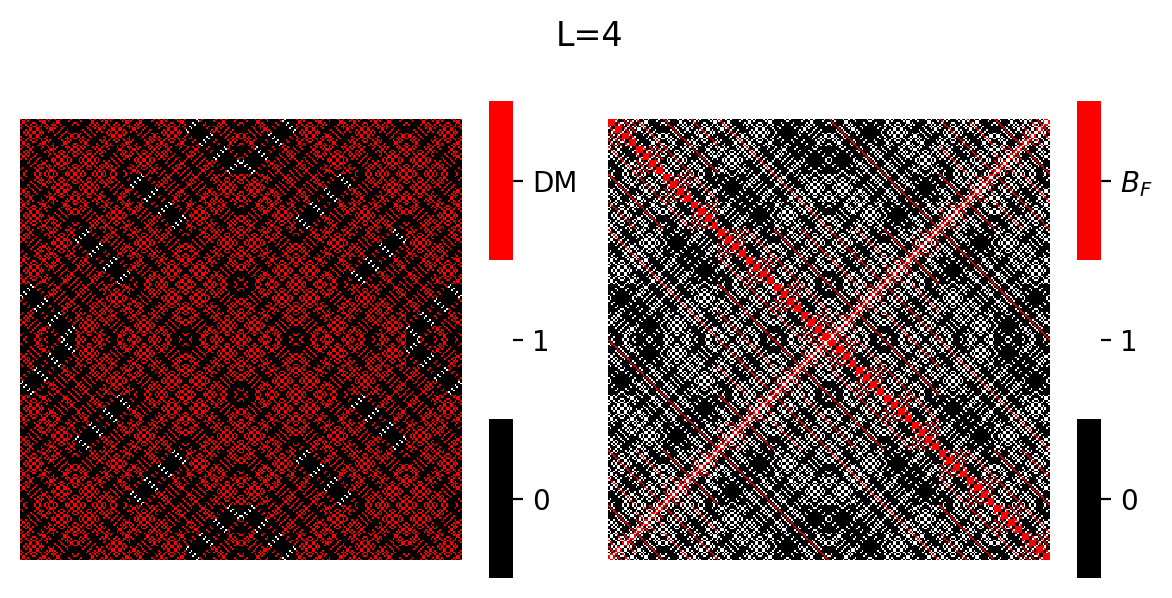

In [45]:
L = 4
basis = SiteBasis(L)
small_basis = SiteBasis(L, True, True)
zero_ops = get_zero_ops(L, small_basis)
sparsity = build_sparsity_matrix(basis, zero_ops)
fig, axs = plt.subplots(1, 2, figsize=(6,3))
# overlay_basis_on_heatmap(sparsity, basis, berbasis0(L), r'$B_0$', "red", axs)
# overlay_basis_on_heatmap(sparsity, basis, berbasis0(L) | berbasis1(L), r'$B_1$', "red", axs[0, 1])
# overlay_basis_on_heatmap(sparsity, basis, berbasis0(L) | berbasis2(L), r'$B_2$', "red", axs[1, 0])
overlay_basis_on_heatmap(sparsity, basis, dm_basis(L), 'DM', "red", axs[0])
overlay_basis_on_heatmap(sparsity, basis, berbasis0(L) | jw_basis(L), r'$B_F$', "red", axs[1])
fig.set_dpi(200)
fig.set_tight_layout(True)
fig.suptitle(f'L={L}')
fig.savefig(f'basis_cov_L{L}.png')

In [9]:
def build_adj_matrix(basis: SiteBasis, marking_ops, zero_ops):
    small_basis = SiteBasis(basis._N, use_rot=True, use_reflect=True)
    sparsity = np.zeros((basis.size(), basis.size()), dtype=np.int8)
    for i, o1 in enumerate(basis._ops):
        for j, o2 in enumerate(basis._ops):
            op = str(PauliString(o1) * PauliString(o2))
            opr = small_basis.rank(op)
            if op in marking_ops and opr - 1 not in zero_ops:
                sparsity[i, j] = 1
    return sparsity

<Axes: >

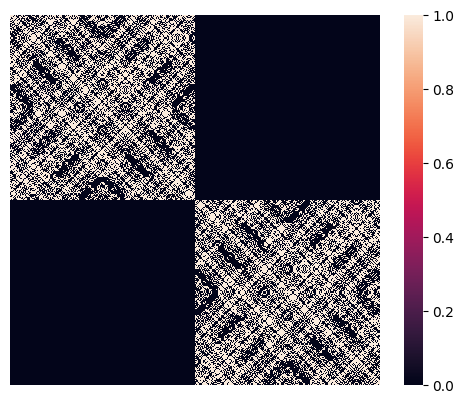

In [276]:
L = 5
basis = SiteBasis(L)
small_basis = SiteBasis(L, True, True)
zero_ops = get_zero_ops(L, small_basis)
adjmat = build_adj_matrix(basis, dm_basis(L), zero_ops)
n_cc, reord = get_reorder(adjmat)
reord_adjmat = adjmat[:, reord][reord, :]
sns.heatmap(reord_adjmat, xticklabels=False, yticklabels=False, square=True)

In [23]:
L = 5
small_basis = SiteBasis(L, True, True)
len(set(small_basis.normalize(x) for x in dm_basis(L)))

42

In [12]:
H = construct_hamil(3, 1)
print(H)
print(np.round(eigvalsh(H.to_matrix()), 4))

-1.00*XXI; -1.00*ZII; -1.00*IXX; -1.00*IZI; -1.00*XIX; -1.00*IIZ
[-4.     -3.4641 -0.     -0.      0.      2.      2.      3.4641]


In [15]:
mapping = {'X':'X','Y':'Z','Z':'Y','I':'I'}
tf = lambda x: ''.join(mapping[c] for c in x)
mapped_H = PauliSum({tf(str(x)): w for x, w in H.terms.items()})
print(mapped_H)
print(np.round(eigvalsh(mapped_H.to_matrix()), 4))

-1.00*XXI; -1.00*YII; -1.00*IXX; -1.00*IYI; -1.00*XIX; -1.00*IIY
[-4.     -3.4641 -0.     -0.      0.      2.      2.      3.4641]


In [31]:
def xyz_model(L: int, h: float) -> PauliSum:
    hamil = Counter()
    for i in range(L):
        t1x, t1y, t1z = None, None, None
        if i<L-1:
            t1x = 'I'*i + 'XX' + 'I'*(L-i-2)
            t1y = 'I'*i + 'YY' + 'I'*(L-i-2)
            t1z = 'I'*i + 'ZZ' + 'I'*(L-i-2)
        else:
            t1x = 'X' + 'I'*(L-2) + 'X'
            t1y = 'Y' + 'I'*(L-2) + 'Y'
            t1z = 'Z' + 'I'*(L-2) + 'Z'
        t2x = 'I'*i+'X'+'I'*(L-i-1)
        t2y = 'I'*i+'Y'+'I'*(L-i-1)
        t2z = 'I'*i+'Z'+'I'*(L-i-1)
        if t1x is not None:
            hamil[t1x] = -1
            hamil[t1y] = -1
            hamil[t1z] = -1
        hamil[t2x] = -h
        hamil[t2y] = -h
        hamil[t2z] = -h
    if L == 2:
        hamil = Counter({'XX': -1, 'YY': -1, 'ZZ': -1, 'XI': -h, 'IX': -h, 'YI': -h, 'IY': -h, 'ZI': -h, 'IZ': -h})
    return PauliSum(hamil)

def spin_chain_rho_ps(hamil: PauliSum):
    H = hamil.to_matrix()
    prob = pc.Problem()
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("min", pc.trace(rho * H))
    prob.add_constraint(pc.trace(rho) == 1)
    prob.add_constraint(rho >> 0)
    prob.solve()
    return PauliSum.from_matrix(np.array(rho.value))

In [133]:
def find_all_correspondences(L, h, h_constructor):
    natural_ordering = 'IXYZ'
    H = h_constructor(L, h)
    spectrum = eigvalsh(H.to_matrix())
    # print('Spectrum =', spectrum)
    for perm_ord in it.permutations(natural_ordering):
        mapping = {natural_ordering[i]: perm_ord[i] for i in range(len(natural_ordering))}
        tf = lambda x: ''.join(mapping[c] for c in x)
        mapped_H = PauliSum({tf(str(x)): w for x, w in H.terms.items()})
        mapped_spectrum = eigvalsh(mapped_H.to_matrix())
        if np.all(np.isclose(mapped_spectrum, spectrum)):
            print(mapping)
        # if np.all(np.isclose(mapped_spectrum, spectrum)):
        #     # print(mapping)
        #     pass
        # else:
        #     print(mapping)
        #     print(mapped_spectrum)

def find_all_pg(L, h, h_constructor):
    natural_ordering = 'IXYZ'
    H = h_constructor(L, h)
    spectrum = eigvalsh(H.to_matrix())
    for o in it.product(natural_ordering, repeat=L):
        p = PauliString(''.join(o))
        mapped_H = PauliSum({str(p * x * p): x.phase(p) * p.phase(x * p) * w for x, w in H.terms.items()})
        # print(mapped_H)
        mapped_spectrum = eigvalsh(mapped_H.to_matrix())
        # if mapped_H == H:
        #     print(p)
        if np.all(np.isclose(mapped_spectrum, spectrum)):
            print(p)

In [107]:
L = 3
rho_ps = spin_chain_rho_ps(construct_hamil(L, 0.5))
com = {}
small_basis = SiteBasis(L, use_rot=True, use_reflect=True)
for pstr, weight in rho_ps.terms.items():
    rw = np.round(weight, 5)
    pnorm = small_basis.normalize(str(pstr))
    if rw in com:
        com[rw].add(pnorm)
    else:
        com[rw] = {pnorm}
print(*com.items(),sep='\n')

(np.complex128(0.125+0j), {'ZZZ', 'III'})
(np.complex128(0.04167+0j), {'IZZ', 'IIZ'})
(np.complex128(0.11384+0j), {'IXX'})
(np.complex128(-0.0305+0j), {'IYY'})
(np.complex128(0.0305+0j), {'XXZ'})
(np.complex128(-0.11384+0j), {'YYZ'})


In [120]:
L = 6
small_basis = SiteBasis(L, use_rot=True, use_reflect=True)
zero_ops = set(small_basis.unrank(x + 1) for x in get_zero_ops(L, small_basis))
nnz_ops = small_basis._opset - zero_ops
dm_ops = set(small_basis.normalize(x) for x in dm_basis(L))
print(nnz_ops - dm_ops)
print(zero_ops)

{'XYZYZY', 'XYXYXY', 'IXXXIY', 'XYZXZY', 'IIXYXY', 'IXIXYX', 'IXIYXY', 'IXYXYZ', 'IIXIYZ', 'IXYIXY', 'IXZYZZ', 'IXIZYZ', 'XYXYZZ', 'XZYYYZ', 'IXXYXZ', 'IIYXZZ', 'IXYZXY', 'IXZYXY', 'IXYXZY', 'XYXYYY', 'IXYXIY', 'IXYZIZ', 'XXXYXY', 'IYXYXZ', 'XYXZYZ', 'XYZXYZ', 'IYXYYZ'}
{'IYXXZZ', 'IXIXZY', 'IXZZYY', 'XXYXYZ', 'IYZXZY', 'IXXXYZ', 'IYIYYZ', 'IZXZYZ', 'IXIYIY', 'IYIYXY', 'IZZXZZ', 'XYYYYZ', 'IXYIZX', 'IXXZYZ', 'IYXZYZ', 'XXXXXY', 'XXXZZZ', 'XXYZZZ', 'IYYZZY', 'IYXXXZ', 'IIZXYZ', 'IXZIYZ', 'IZYXZZ', 'IZYZZZ', 'XYZZYZ', 'IXIZIZ', 'IXZYIZ', 'IYXYYY', 'IXXZXY', 'XXYYXZ', 'IIIIYZ', 'IIXIIY', 'XXXXYZ', 'IZYXYZ', 'IIYZZZ', 'XYYYZZ', 'IYXXYY', 'XZYZZZ', 'IIXZZY', 'IIIXXY', 'IIXYIY', 'IXXXIZ', 'XXXYZZ', 'XYYZZY', 'IXYIZZ', 'IXXIXY', 'IXXZZY', 'XXXYZY', 'IXYYYX', 'IXYZZX', 'YYZYZZ', 'IXZXIY', 'IYYIYZ', 'IXZYYZ', 'IYXZZZ', 'IZXXXZ', 'XYXZXZ', 'XZXZYZ', 'IXXYYX', 'XYYYZY', 'IIXZZZ', 'IXIZZZ', 'IYZIZZ', 'IYYXYZ', 'YYYZZZ', 'IIIIIY', 'XYXYZY', 'IXYIZY', 'IIYIXY', 'IXYYIZ', 'IXZYZY', 'IYYYXZ', 'IIIYXY'